# **Data Cleaning**

## Objectives

* In the data cleaning notebook, we investigate the missing levels and they are handled.

## Inputs

* outputs/datasets/collection/HousePrice.csv

## Outputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv
* outputs/ml_pipeline/data_cleaning/v1/clean_pipeline.pkl and outputs/datasets/cleaned/clean_pipeline.csv

## Additional Comments

* In the Data Collection notebook we already saw that a first cleaning is needed as we could see from the first inspection that the colums **EnclosedPorch** and **WoodDeckSF** had more than half missing values so we drop them.
* We are checking if more data cleaning is necessary.

## Conclusion

* We saw that in total 9 variables had missing values.
* Dop - ['EnclosedPorch'] and ['WoodDeckSF'] have more than 80% of missing values.
* Catergorical Imputation -  ['GarageFinish'], ['BsmtFinType1'] to replace the missing variable by "Missing".
* Median Imputation - ['LotFrontage'], ['BedroomAbvGr'], ['2ndFlrSF'], ['GarageYrBlt'] and ['MasVnrArea'].

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Prediction-heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Prediction-heritage-housing'

# Load Data

We import Panda and load the data from the House Price Records DataFrame.

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HousePrice.csv")
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Data Exploration

First, we check the distribution and shape of a variable with missing data by computing the variables:

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

Thanks to the report above, we can see that we have 9 colums with missing data. But we would need more information to handle them: 

In [6]:
df[vars_with_missing_data].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2ndFlrSF       1374 non-null   float64
 1   BedroomAbvGr   1361 non-null   float64
 2   BsmtFinType1   1346 non-null   object 
 3   EnclosedPorch  136 non-null    float64
 4   GarageFinish   1298 non-null   object 
 5   GarageYrBlt    1379 non-null   float64
 6   LotFrontage    1201 non-null   float64
 7   MasVnrArea     1452 non-null   float64
 8   WoodDeckSF     155 non-null    float64
dtypes: float64(7), object(2)
memory usage: 102.8+ KB


## Correlation and PPS Analysis

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate Correlations and Power Predictive Score

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The 

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


Display at Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



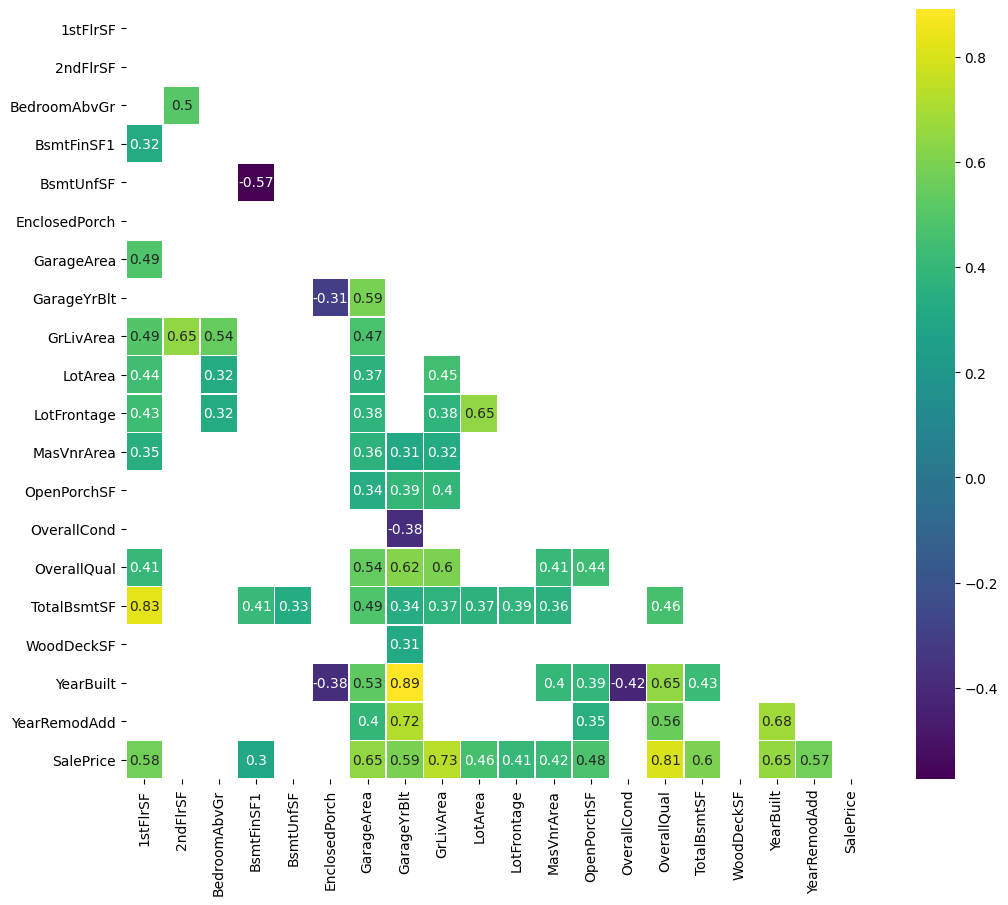



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



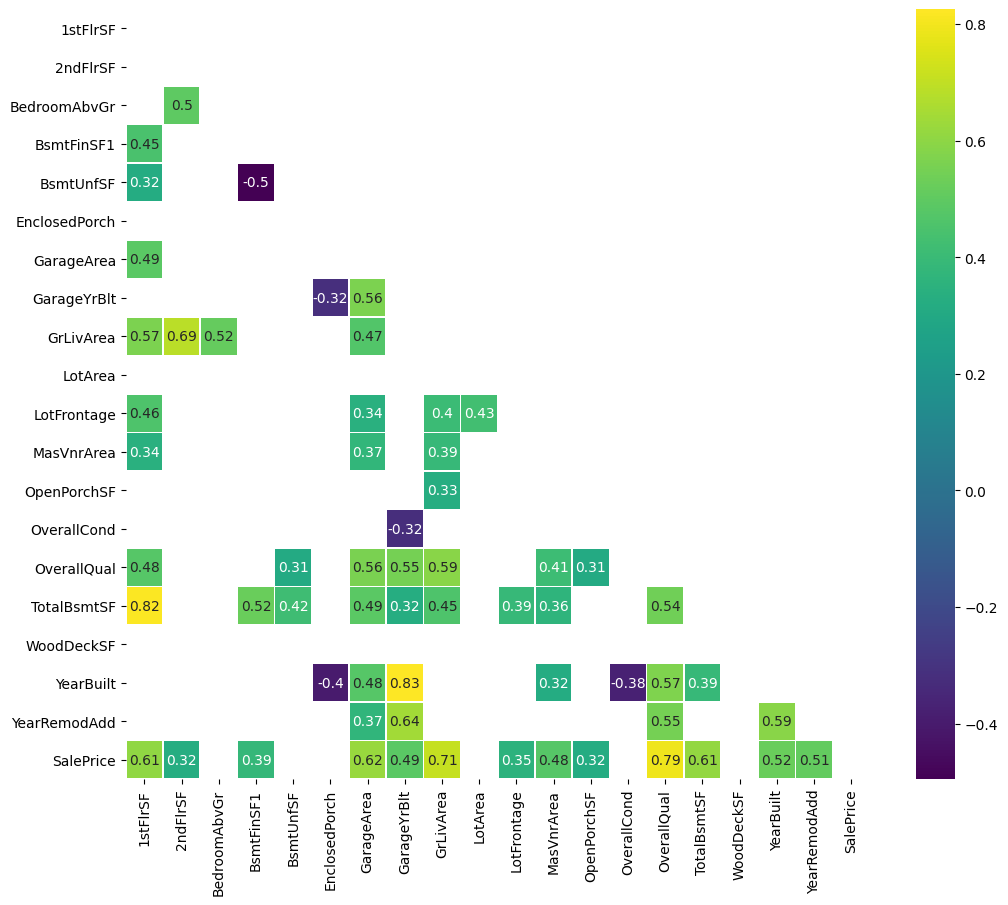



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



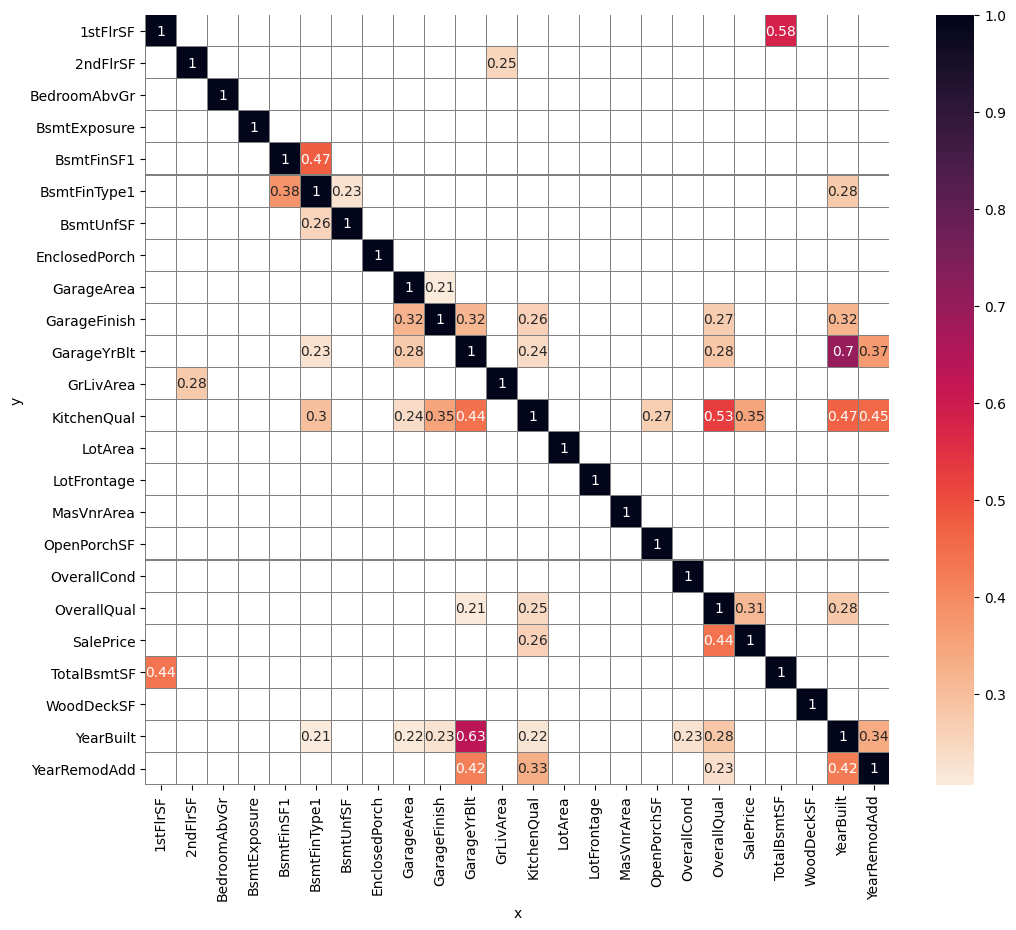

In [9]:
%matplotlib inline
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman,
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.3, PPS_Threshold = 0.2,
                  figsize=(12,10), font_annot = 10)

# Data Cleaning

## Assessing Missing Data Levels

Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type:

In [10]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

Check missing data levels for the collected dataset:

In [11]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


## Data Cleaning Spreadsheet Summary

From our finding, we list the data cleaning approaches for the missing values:

1. We set an approximate threshold of 20% for drop. ['EnclosedPorch', 'WoodDeckSF'] are dropped as they are above the threshold. of missing values. As we can see that the units in the data start at 0 for these features, we can't really know that the missing values would be equal to missing features in the targeted houses.

2. As the rest of the variables don't have an important percentage of missing variables so we are going to use imputation methods, but we should first check their impact:
 * ['GarageFinish'] and ['BsmtFinType1'] are categorical variables so we are going to check the impact of imputing 'Missing'.
 * ['BedroomAbvGr'], ['2ndFlrSF'], ['GarageYrBlt'] and ['MasVnrArea'] are numerical variables so we are going to first check the impact of a Mean imputation.
 * As ['LotFrontage'] compare to the other numerical variables has units not starting at 0, so we will check the impact of a Mean imputation and an Arbitrary Number Imputer.

## Dealing with Missing Data

First we are loading the DataCleaningEffect() function we studied in the feature-engine lesson to compare the before and after effects of data cleaning thanks to plots. 

So we are now checking the impact of the imputation methods:

In [12]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):
  """
  Function to visualize data cleaning effect
  """
  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

As we have numerical and categorical data, we would need to check the effect of the data cleaning seperatly.

#### For categorical variables:

We will impute 'Missing' on categorical variables ['GarageFinish'] and ['BsmtFinType1']:

In [13]:
from feature_engine.imputation import CategoricalImputer # Select an imputation method

variables_method = ['GarageFinish', 'BsmtFinType1'] # Select variables
variables_method

['GarageFinish', 'BsmtFinType1']

Then we create a separate DataFrame to apply the method:

In [14]:
imputer = CategoricalImputer(imputation_method='missing', fill_value='Missing',
                             variables=variables_method)

df_method = imputer.fit_transform(df)

Finally, we assess the effect on the variable distribution:


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['GarageFinish', 'BsmtFinType1'] 




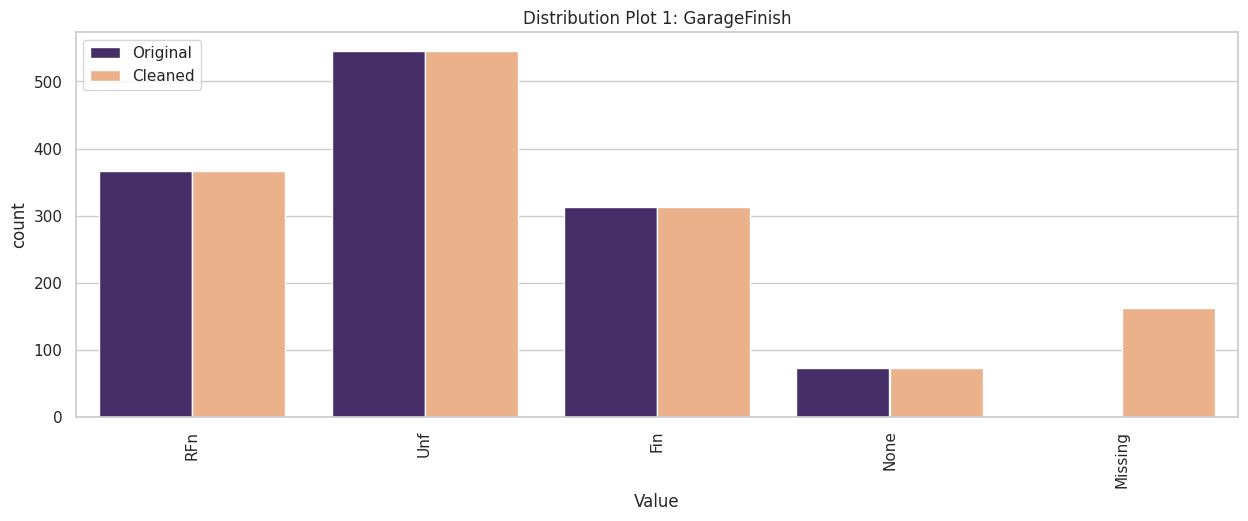

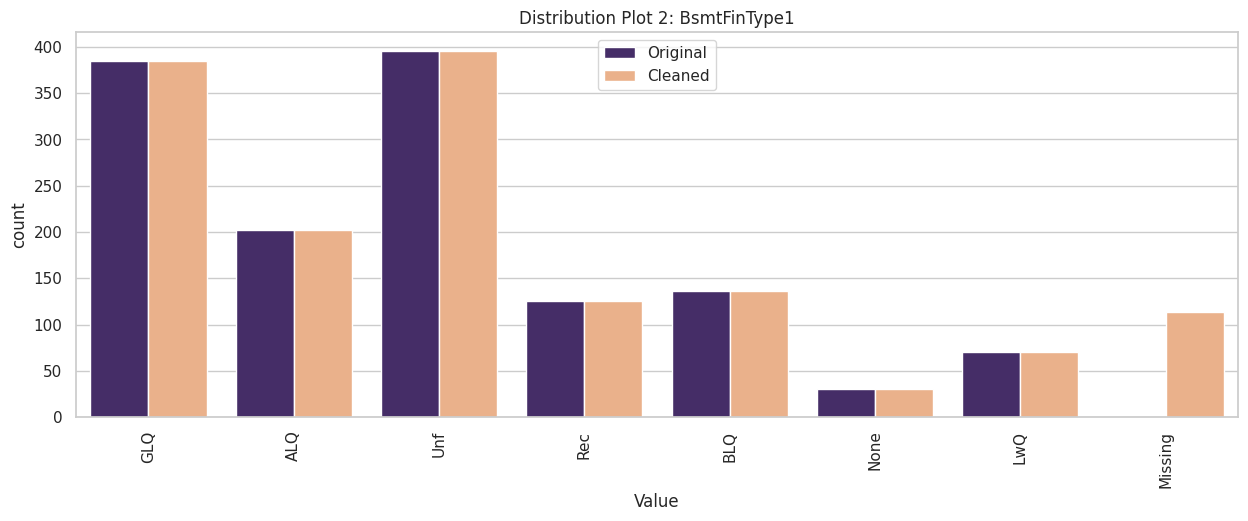

In [15]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

#### For numerical data:

* First, we are using **Median Imputation** as it tends to be robust to outliers and preserve the overall distribution of the data:

In [16]:
from feature_engine.imputation import MeanMedianImputer # Select an imputation method

variables_method = ['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'] # Select variables
variables_method

['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']

In [17]:
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
df_method = imputer.fit_transform(df)


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'] 




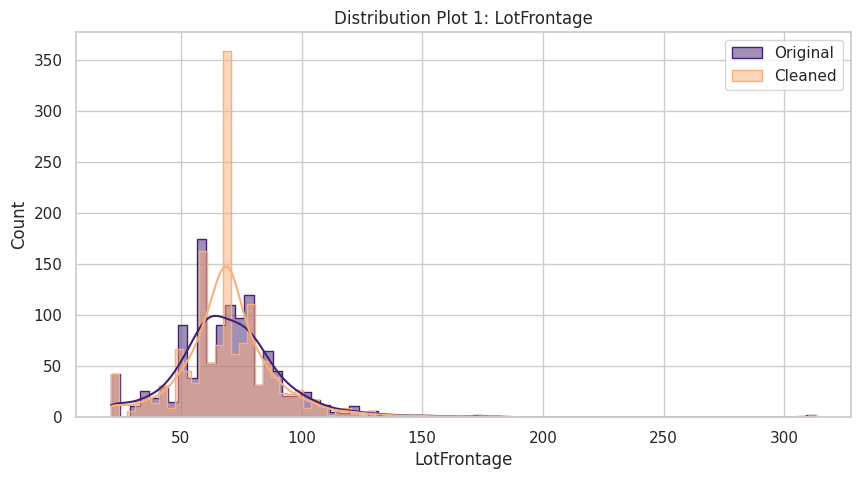

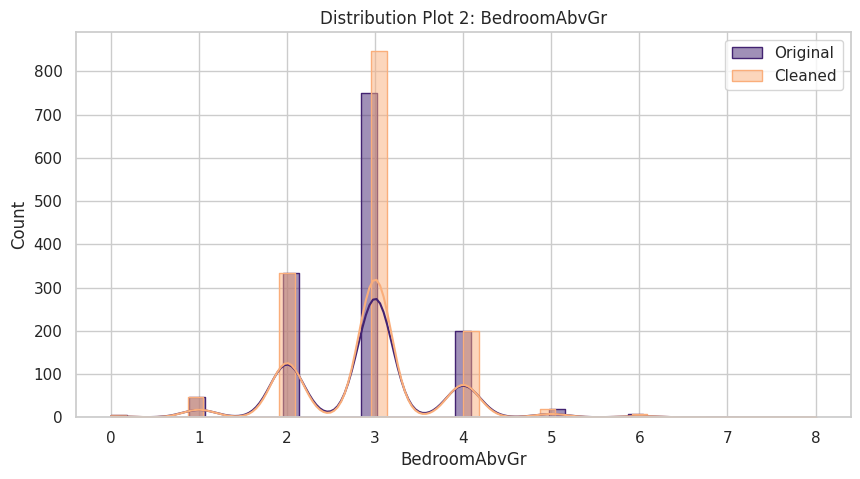

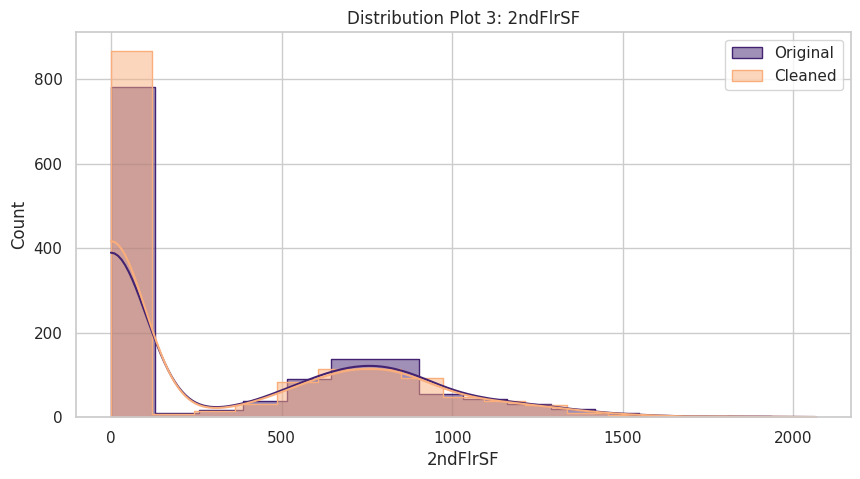

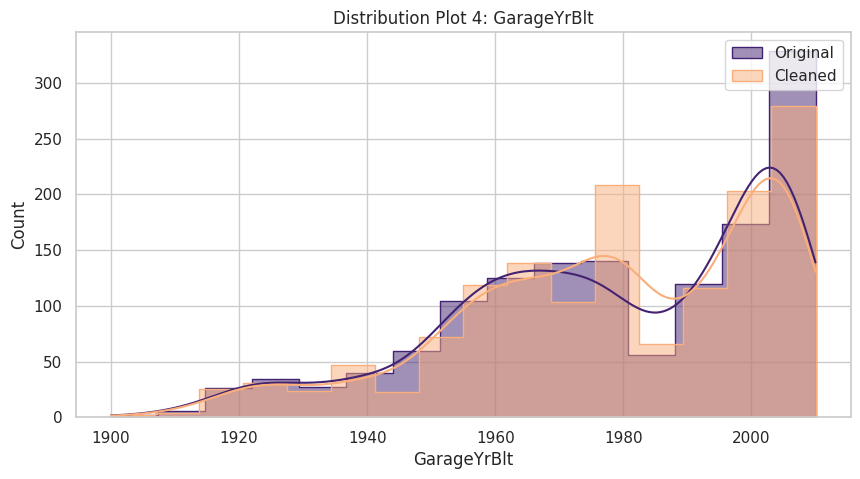

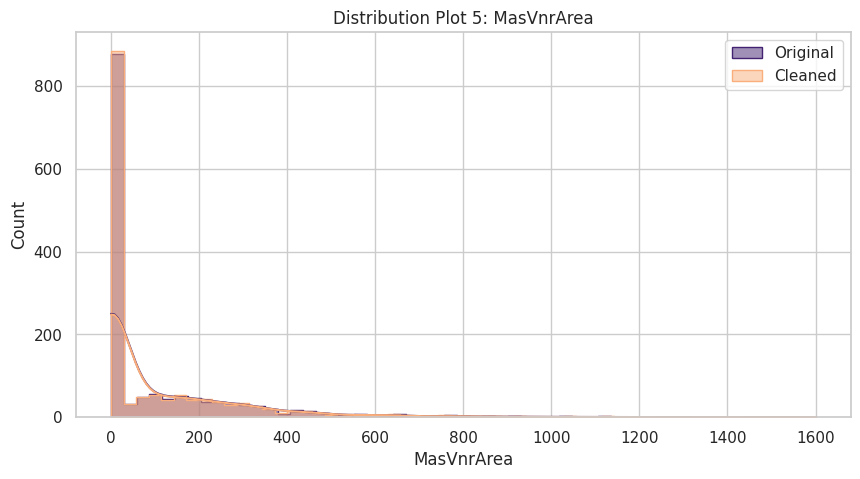

In [18]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

* Second, we are checking for the Arbitrary Number Imputation for ['LotFrontage'] only:

In [19]:
from feature_engine.imputation import ArbitraryNumberImputer

variables_method = ['LotFrontage']
variables_method

['LotFrontage']


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage'] 




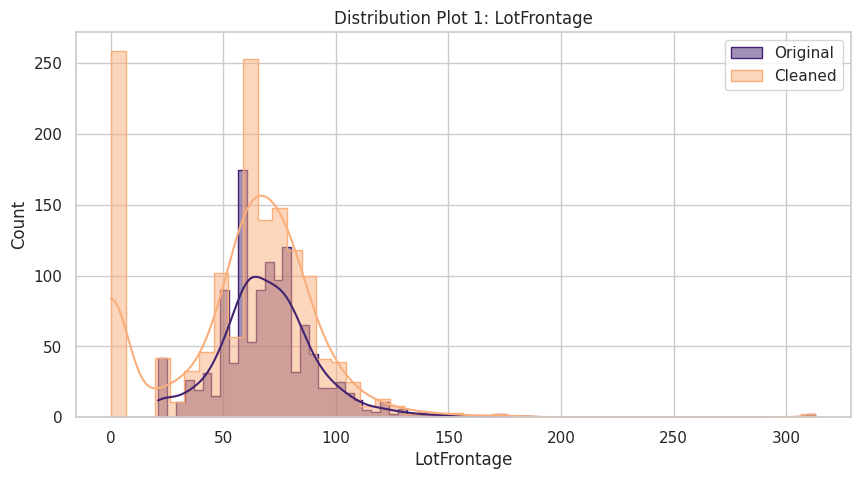

In [20]:
imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

### Data Cleaning Summary


List of the data cleaning approaches:
* We will drop ['EnclosedPorch'] and ['WoodDeckSF'] as we have a high percentagge of missing values.
* We will do a Categorical Imputation for ['GarageFinish'] and ['BsmtFinType1'].
* Thanks to Median Imputation plot of the features ['LotFrontage'], ['BedroomAbvGr'], ['2ndFlrSF'], ['GarageYrBlt'] and ['MasVnrArea'], we can see that the function plots in the same Axes the distribution before and after applying the method.
* Indeed, we won't use  Arbitrary Number Imputation for ['LotFrontage'] as the shape of the data distribution changed significantly compare to the Median Imputation.

### Split Train and Test Set

We will now split the data:

In [21]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


### Drop Variables

The first step will be to drop variables with more than 80% of missing data.

In [22]:
from feature_engine.selection import DropFeatures

variables_method = ['EnclosedPorch', 'WoodDeckSF']
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet), imputer.transform(TestSet)

###  Imputation methods

Then we will apply the two different imputations methods choosen before.

1. Categorical Imputation

In [23]:
variables_method = ['GarageFinish', 'BsmtFinType1']
imputer = CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

2. Median Imputation

In [24]:
variables_method = ['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

---

## Data Cleaning Pipeline

To summarize, 3 different data cleaning methods were used and then we can apply them to the dataset.

In [25]:
from sklearn.pipeline import Pipeline

clean_pipeline = Pipeline([
      ( 'drop',  DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF']) ),
      ( 'categorical',  CategoricalImputer(imputation_method='missing',
                                     fill_value='Missing',
                                     variables=['GarageFinish' , 'BsmtFinType1']) ),
      ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']) )
])
clean_pipeline

df = clean_pipeline.fit_transform(df)
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.000000,3.000000,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.000000,3.000000,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.000000,3.000000,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,348.524017,2.869214,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,348.524017,4.000000,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


---

# Push files to Repo

In [26]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/cleaned folder
except Exception as e:
  print(e)


[Errno 17] File exists: 'outputs/datasets/cleaned'


## Train Set

In [27]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False) # Save the Train Set

## Test Set

In [28]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False) # Save the Test Set

## Clean Pipeline

Create the first version of cleaned Pipeline:

In [29]:
import joblib

path = 'outputs/ml_pipeline/data_cleaning/v1'

try:
  os.makedirs(name=path) # create outputs/ml_pipeline/data_cleaning/v1 folder
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/data_cleaning/v1'


In [30]:
joblib.dump(value=clean_pipeline, filename=f"{path}/clean_pipeline.pkl")

['outputs/ml_pipeline/data_cleaning/v1/clean_pipeline.pkl']

In [31]:
df.to_csv("outputs/datasets/cleaned/clean_pipeline.csv", index=False)